In [7]:
import torch
import torchvision.transforms as transforms
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define a range of noise levels
noise_levels = [1.8, 1.9, 2]  # Adjust as needed

# Function to add Gaussian noise
def add_gaussian_noise(tensor, mean=0.0, std=0.2):
    noise = torch.randn(tensor.size()) * std + mean
    noisy_tensor = tensor + noise
    return torch.clamp(noisy_tensor, 0, 1)

# Function to create the dataset with the given noise level
def get_mnist_cifar_dataset(noise_std):
    mnist_transform = transforms.Compose([
        transforms.Resize((32, 32)),  # Resize to match CIFAR
        transforms.Grayscale(num_output_channels=3),  # Convert to RGB
        transforms.ToTensor(),
        transforms.Lambda(lambda x: add_gaussian_noise(x, std=noise_std))  # Apply Gaussian noise
    ])

    cifar_transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor()
    ])

    mnist_data = torchvision.datasets.MNIST(root='./data', train=True, transform=mnist_transform, download=True)
    cifar_data = torchvision.datasets.CIFAR10(root='./data', train=True, transform=cifar_transform, download=True)

    return mnist_data, cifar_data


In [8]:
from torch.utils.data import Dataset
import random

# Define the mapping of MNIST digits (0-9) to CIFAR classes (10 categories)
MNIST_TO_CIFAR_MAP = {
    0: 0,  # 0 → airplane
    1: 1,  # 1 → automobile
    2: 2,  # 2 → bird
    3: 3,  # 3 → cat
    4: 4,  # 4 → deer
    5: 5,  # 5 → dog
    6: 6,  # 6 → frog
    7: 7,  # 7 → horse
    8: 8,  # 8 → ship
    9: 9   # 9 → truck
}

class CombinedDataset(Dataset):
    def __init__(self, mnist_dataset, cifar_dataset):
        self.mnist = mnist_dataset
        self.cifar = cifar_dataset
        
        # Organize CIFAR images by label
        self.cifar_by_class = {i: [] for i in range(10)}
        for img, label in self.cifar:
            self.cifar_by_class[label].append(img)

    def __len__(self):
        return len(self.mnist)  # Use MNIST length as the base

    def __getitem__(self, idx):
        mnist_img, mnist_label = self.mnist[idx]
        
        # Get CIFAR class corresponding to this MNIST digit
        cifar_class = MNIST_TO_CIFAR_MAP[mnist_label]
        
        # Pick a random CIFAR image from this class
        cifar_imgs = self.cifar_by_class[cifar_class]
        cifar_img = random.choice(cifar_imgs) if cifar_imgs else torch.zeros_like(mnist_img)  # Fallback if empty

        # Concatenate along the width dimension
        combined_img = torch.cat((mnist_img, cifar_img), dim=2)

        return combined_img, cifar_class  # Target is the CIFAR class


Files already downloaded and verified


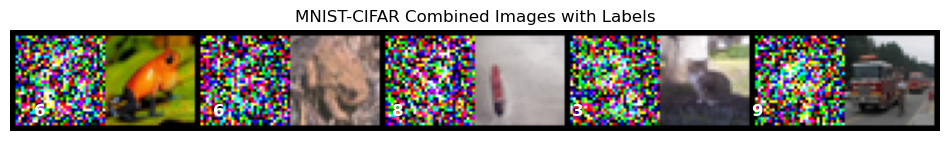

In [9]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

mnist_data, cifar_data = get_mnist_cifar_dataset(1.2)
combined_dataset = CombinedDataset(mnist_data, cifar_data)
combined_loader = DataLoader(combined_dataset, batch_size=32, shuffle=True)

# Function to show a batch of combined MNIST-CIFAR images with their labels
def show_combined_images_with_labels(dataloader, num_images=5):
    data_iter = iter(dataloader)
    images, labels = next(data_iter)  # Get first batch

    # Select only the first `num_images` images
    images = images[:num_images]
    labels = labels[:num_images]  # Corresponding labels
    
    # Apply the blackout
    # images[:, :, :, 32:] = 0

    # Create a grid of images
    grid_img = vutils.make_grid(images, nrow=num_images, padding=2, normalize=True)
    
    # Display the images
    plt.figure(figsize=(12, 4))
    plt.imshow(grid_img.permute(1, 2, 0))  # Change from (C, H, W) to (H, W, C) for display
    plt.axis("off")

    # Add labels to the images
    for i in range(num_images):
        label = labels[i].item()  # Get label (make sure it's a scalar)
        plt.text(
            i * 64 + 8,  # x position
            30,  # y position (near the bottom of the image)
            str(label),  # Label text
            color='white',  # White color for the text
            fontsize=12,
            fontweight='bold'
        )

    plt.title("MNIST-CIFAR Combined Images with Labels")
    plt.show()

# Call function to display images with labels
show_combined_images_with_labels(combined_loader)


In [10]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 16 * 8, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 classes (same as CIFAR)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [11]:
def train_and_evaluate(noise_std, num_epochs=5):
    mnist_data, cifar_data = get_mnist_cifar_dataset(noise_std)
    combined_dataset = CombinedDataset(mnist_data, cifar_data)
    train_loader = DataLoader(combined_dataset, batch_size=64, shuffle=True)

    model = SimpleCNN()  # Removed .cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)  # No need for .cuda()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Test the model on different conditions
    def test_model(test_loader, blackout_type):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                
                # Apply blackout
                if blackout_type == "mnist":
                    images[:, :, :, :32] = 0  # Set MNIST part to black
                elif blackout_type == "cifar":
                    images[:, :, :, 32:] = 0  # Set CIFAR part to black
                
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        return correct / total

    # Create test sets
    test_loader = DataLoader(combined_dataset, batch_size=64, shuffle=False)
    
    acc_normal = test_model(test_loader, "none")
    acc_mnist_blackout = test_model(test_loader, "mnist")
    acc_cifar_blackout = test_model(test_loader, "cifar")

    return acc_normal, acc_mnist_blackout, acc_cifar_blackout


In [12]:
results = {}

for noise in noise_levels:
    print(f"Running experiment with noise std: {noise}")
    acc_normal, acc_mnist_blackout, acc_cifar_blackout = train_and_evaluate(noise)

    results[noise] = {
        "normal": acc_normal,
        "mnist_blackout": acc_mnist_blackout,
        "cifar_blackout": acc_cifar_blackout
    }

# Print results
for noise, acc in results.items():
    print(f"Noise Std: {noise}")
    print(f"  Normal Accuracy: {acc['normal']:.4f}")
    print(f"  MNIST Blackout Accuracy: {acc['mnist_blackout']:.4f}")
    print(f"  CIFAR Blackout Accuracy: {acc['cifar_blackout']:.4f}")
    print("-" * 40)


Running experiment with noise std: 1.8
Files already downloaded and verified
Running experiment with noise std: 1.9
Files already downloaded and verified
Running experiment with noise std: 2
Files already downloaded and verified
Noise Std: 1.8
  Normal Accuracy: 0.8696
  MNIST Blackout Accuracy: 0.3883
  CIFAR Blackout Accuracy: 0.4857
----------------------------------------
Noise Std: 1.9
  Normal Accuracy: 0.8714
  MNIST Blackout Accuracy: 0.3321
  CIFAR Blackout Accuracy: 0.5140
----------------------------------------
Noise Std: 2
  Normal Accuracy: 0.8435
  MNIST Blackout Accuracy: 0.4011
  CIFAR Blackout Accuracy: 0.4546
----------------------------------------
